## LOAD LIBRARIES

In [1]:
# ENVIRONMENT
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import pathlib
from glob import glob

import warnings
warnings.filterwarnings("ignore")

# TENSORFLOW 2.0
import tensorflow as tf
print(tf.__version__)
print('GPU available:', tf.test.is_gpu_available())

from tensorflow.keras.models import Model
from tensorflow.python.keras.layers import Add, BatchNormalization, Conv2D, Dense, Flatten, Input, LeakyReLU, PReLU, Lambda, MaxPool2D
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError, MeanSquaredError
binary_cross_entropy = BinaryCrossentropy()

from tensorflow.keras.metrics import Mean

from tensorflow.keras import backend as K
# from tensorflow import keras
# from keras import backend as K
from tensorflow.python.data.experimental import AUTOTUNE

# ESSENTIAL 
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

# VISUALIZER
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline
from IPython import display

# UTILS
import time
import datetime 
from datetime import date
from tqdm import tqdm

2.1.0-dlenv_tfe
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available: True


In [2]:
# Setting seed
tf.random.set_seed(11)
np.random.seed(11)

### Pre-trained VGG 19

In [ ]:
# Pre-trained VGG 
from tensorflow.python.keras.applications.vgg19 import VGG19
vgg_19 = VGG19(input_shape=(None, None, 3), weights='imagenet', include_top=False)

## LOAD DIRECTORIES

```
GAN
│   
└───data
│   │
│   └───real_images
│   │    │  
│   │    └─── transmission
│   │    │  
│   │    └─── blended
│   │
│   └───synthetic_images
│   │    │  
│   │    └─── transmission
│   │    │  
│   │    └─── reflection
│   │
│   └───test
│        │  
│        └─── transmission
│        │  
│        └─── blended
│   
└───logs
    │
    └─── ckpts 
    │    │  
    │    │  
    │    └─── train 
    │
    └─── output
         │  
         │  
         └─── train 

```

In [3]:
pwd

'/home/jupyter/Tin-Final-Proj'

In [5]:
# Dataset Directories
DATA_DIR = "./data"

BLENDED_TRAIN_DIR      = os.path.join(DATA_DIR, 'real_images/blended')    
TRANSMISSION_TRAIN_DIR = os.path.join(DATA_DIR, 'real_images/transmission')

SYN_REFLECTION_TRAIN_DIR = os.path.join(DATA_DIR, 'synthetic_images/reflection')
SYN_TRANSMISSION_TRAIN_DIR = os.path.join(DATA_DIR, 'synthetic_images/transmission')

BLENDED_TEST_DIR = os.path.join(DATA_DIR, 'test/blended')    
TRANSMISSION_TEST_DIR = os.path.join(DATA_DIR, 'test/transmission')

# Training Support Directories 
LOG_DIR = './logs'

CKPTS_DIR  = os.path.join(LOG_DIR, 'ckpts')
OUTPUT_DIR = os.path.join(LOG_DIR, 'output')

In [6]:
TRAIN_CKPTS_DIR = os.path.join(CKPTS_DIR, 'train')
# PRETR_CKPTS_DIR = os.path.join(CKPTS_DIR, 'pretrain')

In [7]:
BLENDED_TRAIN_DIR, TRANSMISSION_TRAIN_DIR, TRAIN_CKPTS_DIR

('./data/real_images/blended',
 './data/real_images/transmission',
 './logs/ckpts/train')

## PREPARE DATASET

### Prepare synthetic data

In [8]:
SYN_REFLECTION_TRAIN_DIR = './reflection_layer'
SYN_TRANSMISSION_TRAIN_DIR = './transmission_layer'

SYN_BLENDED_DIR = './synthetic_images'
MASK_DIR = './reflection_mask_layer'

In [9]:
IMG_EXTENSIONS = ['.jpg', '.JPG', '.jpeg', '.JPEG',
                  '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP']

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

In [10]:
path_transmission = []
path_reflection   = []
path_synthetic    = []

for root, _, fnames in sorted(os.walk(SYN_REFLECTION_TRAIN_DIR)):
    for fname in fnames:
        if is_image_file(fname):
            _path_trans = os.path.join(SYN_TRANSMISSION_TRAIN_DIR, fname)
            _path_refle = os.path.join(SYN_REFLECTION_TRAIN_DIR, fname)
            _path_syn = os.path.join(SYN_BLENDED_DIR, fname)
            
            path_transmission.append(_path_trans)
            path_reflection.append(_path_refle)
            path_synthetic.append(_path_syn)

In [11]:
assert len(path_transmission) == len(path_reflection)
assert len(path_synthetic) == len(path_transmission)

num_train_syn = len(path_transmission)

In [12]:
import mahotas 
import imutils

import matplotlib.pyplot as plt
%matplotlib inline

------------------------------------------------

In [35]:
import scipy.stats as st

# functions for synthesizing images with reflection (details in the paper)
def gkern(kernlen=100, nsig=1):
    """Returns a 2D Gaussian kernel array."""
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    kernel = kernel/kernel.max()
    return kernel

# create a vignetting mask
g_mask = gkern(560,3)
# g_mask = gkern(720,3)
g_mask = np.dstack((g_mask,g_mask,g_mask))

k_sz=np.linspace(1,5,80) # for synthetic images

In [78]:
def syn_data(t,r,sigma):
    t = np.power(t,2.2)
    r = np.power(r,2.2)
    
    sz = int(2*np.ceil(2*sigma)+1)
    r_blur = cv2.GaussianBlur(r, (sz,sz), sigma,sigma,0)
    blend = r_blur + t
    
    att= 1.08 + np.random.random()/10.0
    
    for i in range(3):
        maski = blend[:,:,i]>1
        mean_i= max(1., np.sum(blend[:,:,i]*maski)/(maski.sum()+1e-6))
        r_blur[:,:,i] = r_blur[:,:,i]-(mean_i-1)*att
        
    r_blur[r_blur>=1]=1
    r_blur[r_blur<=0]=0

    h,w = r_blur.shape[0:2]
#     neww = np.random.randint(0, 560-w-10)
#     newh = neww
#     # newh = np.random.randint(0, 560-h-10)
    
#     w = np.random.randint(256, 480)
#     h = w
    neww = np.random.randint(0, 560-w-10)
    newh = neww

    alpha1 = g_mask[newh: newh+h, neww: neww+w, :]
    alpha2 = 1-np.random.random()/5.0;
    
    r_blur_mask = np.multiply(r_blur, alpha1)
    blend2 = r_blur_mask + t*alpha2
    
#     blend = r_blur + t*alpha2
    
    r_blur_mask = np.float32(r_blur_mask) 
    blend2 = np.float32(blend2)
    
    r_blur_mask[r_blur_mask >=1]=1
    r_blur_mask[r_blur_mask <=0]=0
    
    blend2[blend2 >=1]=1
    blend2[blend2 <=0]=0
    
#     t=np.power(t,1/2.2)
#     r_blur_mask=np.power(r_blur_mask,1/2.2)
    
#     blend = np.power(blend,1/2.2)
#     blend[blend>=1]=1
#     blend[blend<=0]=0

    return t, r_blur_mask, blend2 #, r_blur, blend

In [84]:
k_sz=np.linspace(1,5,80) # for synthetic images

def gen_and_save_synthetic_image(path_transmission, path_reflection, path_synthetic,no_of_img= 0):
    invalid_reflection = []
    invalid_blended = []
    
    count = 0
    
    for i in range(no_of_img):
        input_trans = cv2.imread(path_transmission[i], -1)
        input_refle = cv2.imread(path_reflection[i], -1) 

        neww = 480
#         neww = np.random.randint(256, 480)
        newh = round((neww/input_trans.shape[1]) *input_trans.shape[0])  
        
        input_trans = cv2.resize(np.float32(input_trans), (neww,newh), cv2.INTER_CUBIC) /255.
        input_refle = cv2.resize(np.float32(input_refle), (neww,newh), cv2.INTER_CUBIC) /255.
        
        sigma = k_sz[np.random.randint(0, len(k_sz))]
                                     
        if np.mean(input_trans)*1/2 > np.mean(input_refle):
            continue
        
        output_image_t, output_image_r, syn_img = syn_data(input_trans, input_refle, sigma)

        if output_image_r.max() < 0.15 or output_image_t.max() < 0.15:
            invalid_reflection.append(path_synthetic[i])
            continue
            
        if output_image_t.max() < 0.1:
            invalid_blended.append(path_synthetic[i])
            continue

#         plt.imshow(cv2.cvtColor(syn_img, cv2.COLOR_BGR2RGB))
#         plt.show()
        plt.imsave(path_synthetic[i], cv2.cvtColor(syn_img, cv2.COLOR_RGB2BGR))
        plt.imsave(os.path.join(MASK_DIR, os.path.split(path_synthetic[i])[1]), cv2.cvtColor(output_image_r, cv2.COLOR_RGB2BGR))
        
#         cv2.imwrite(path_synthetic[i], cv2.cvtColor(syn_img, cv2.COLOR_RGB2BGR))
#         cv2.imwrite(os.path.join(MASK_DIR, os.path.split(path_synthetic[2])[1]), cv2.cvtColor(output_image_r, cv2.COLOR_RGB2BGR))
        count += 1
    
        print('.', end='')
        if (i+1) % 100 == 0:
            print()    
        
    print('Save {} images'.format(count))
        
#         if flag:
#             display_list = [output_image_t, output_image_r, syn_img]
#             title = ['Trans Image', 'Reflect Image', 'Syn Image']

#             for i in range(3):
#                 plt.subplot(1, 3, i+1)
#                 plt.title(title[i])
#                 # getting the pixel values between [0, 1] to plot it.
# #                 plt.imshow(imutils.opencv2matplotlib(display_list[i])) 
#                 plt.imshow(cv2.cvtColor(display_list[i], cv2.COLOR_BGR2RGB))
# #                 plt.imshow(display_list[i])
#                 plt.axis('off')
#                 plt.show()

In [85]:
gen_and_save_synthetic_image(path_transmission, path_reflection, path_synthetic, no_of_img= 6000)

............................................................................................
........................................................................................
........................................................................................
.......................................................................................
....................................................................................
........................................................................................
..........................................................................................
............................................................................................
............................................................................................
.....................................................................................................................................................................................
........

------------------------------------------------

In [14]:
import scipy.stats as st

# functions for synthesizing images with reflection (details in the paper)
def gkern(kernlen=100, nsig=1):
    """Returns a 2D Gaussian kernel array."""
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    kernel = kernel/kernel.max()
    return kernel

# create a vignetting mask
# g_mask = gkern(560,3)
g_mask = gkern(640,3)
g_mask = np.dstack((g_mask,g_mask,g_mask))

k_sz=np.linspace(1,5,80) # for synthetic images

In [57]:
def syn_data(t,r,sigma):
    t = np.power(t,2.2)
    r = np.power(r,2.2)
    
    sz = int(2*np.ceil(2*sigma)+1)
    r_blur = cv2.GaussianBlur(r, (sz,sz), sigma,sigma,0)
    blend = r_blur + t
    
    att= 1.08 + np.random.random()/10.0
    
    for i in range(3):
        maski = blend[:,:,i]>1
        mean_i= max(1., np.sum(blend[:,:,i]*maski)/(maski.sum()+1e-6))
        r_blur[:,:,i] = r_blur[:,:,i]-(mean_i-1)*att
        
    r_blur[r_blur>=1]=1
    r_blur[r_blur<=0]=0

    h,w = r_blur.shape[0:2]
    neww = np.random.randint(0, 560-w-10)
    newh = neww
    # newh = np.random.randint(0, 560-h-10)

    alpha1 = g_mask[newh: newh+h, neww: neww+w, :]
    alpha2 = 1-np.random.random()/5.0;
    
    r_blur_mask = np.multiply(r_blur, alpha1)
    blend2 = r_blur_mask + t*alpha2
    
    blend = r_blur + t*alpha2
    
    r_blur_mask = np.float32(r_blur_mask)
    blend2 = np.float32(blend2)
    
#     t=np.power(t,1/2.2)
#     r_blur_mask=np.power(r_blur_mask,1/2.2)
    
#     blend = np.power(blend,1/2.2)
#     blend[blend>=1]=1
#     blend[blend<=0]=0

    return t,r_blur_mask,blend , r_blur , alpha1, r_blur_mask, blend2

In [17]:
k_sz=np.linspace(1,5,80) # for synthetic images

def gen_and_save_synthetic_image(path_transmission, path_reflection, path_synthetic,no_of_img= 0):
    invalid_reflection = []
    invalid_blended = []
    flag = True
    
    for i in range(no_of_img):
        input_trans = cv2.imread(path_transmission[i], -1)
        input_refle = cv2.imread(path_reflection[i], -1) 
        
#         if (input_trans.shape[0] < input_refle.shape[0]) or (input_trans.shape[1] < input_refle.shape[1]):
#             input_refle = cv2.resize(np.float32(input_refle, (input_trans.shape[0], input_trans.shape[1])), cv2.INTER_CUBIC)
        neww = np.random.randint(256, 480)
        newh = round((neww/input_trans.shape[1]) *input_trans.shape[0])  
        
        input_trans = cv2.resize(np.float32(input_trans), (neww,newh), cv2.INTER_CUBIC) /255.
        input_refle = cv2.resize(np.float32(input_refle), (neww,newh), cv2.INTER_CUBIC) /255.
        
        sigma = k_sz[np.random.randint(0, len(k_sz))]
                                     
        if np.mean(input_trans)*1/2 > np.mean(input_refle):
            continue
        output_image_t, output_image_r, syn_img = syn_data(input_trans, input_refle, sigma)

        if output_image_r.max() < 0.15 or output_image_t.max() < 0.15:
            invalid_reflection.append(path_synthetic[i])
            flag = False
            continue
        if output_image_t.max() < 0.1:
            invalid_blended.append(path_synthetic[i])
            flag = False
            continue
#         if flag: 
#             cv2.imwrite(blended_name[i], input_image))    
             
        if flag:
            display_list = [output_image_t, output_image_r, syn_img]
            title = ['Trans Image', 'Reflect Image', 'Syn Image']

            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.title(title[i])
                # getting the pixel values between [0, 1] to plot it.
#                 plt.imshow(imutils.opencv2matplotlib(display_list[i])) 
                plt.imshow(cv2.cvtColor(display_list[i], cv2.COLOR_BGR2RGB))
#                 plt.imshow(display_list[i])
#                 plt.axis('off')
                plt.show()

---------------------------------------

In [89]:
def test_return(issyn = False):
    a = 1
    b = 2
    if issyn:
        return a, None
    else:
        return a, b

In [90]:
a, b = test_return(issyn= False)

### Configuration

In [9]:
## Image Configuration
CHANNEL = 3
IMG_WIDTH = 128
IMG_HEIGHT = 128

CROP_SIZE = [128, 300]

# Training Configuration 
BATCH_SIZE = 1 #FLAG, set low BATCH_SIZE
BUFFER_SIZE = 50

GAN_GEN_LR = 2e-4
GAN_DIS_LR = 1e-4
OPT_BETA_1 = 0.5

EPS = 1e-12

### Load & Pre-process Data

In [10]:
def load_paths_from_directory(directory, format_type='jpeg'):
    return sorted(glob(os.path.join(directory, "*.{}".format(format_type))))

In [11]:
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels= 3)
    
    input_image = tf.cast(image, tf.float32)
    
    return input_image

In [17]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], 
                                  method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                 method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
    return input_image, real_image

In [18]:
# def random_resize(input_image, real_image):
#     _w = tf.shape(input_image)[0]
#     _h = tf.shape(input_image)[1]
#     ratio = _w /_h
#     ratio = tf.cast(ratio, dtype= 'float32')
    
#     new_w = tf.random.uniform(shape=(), minval= CROP_SIZE[0], maxval= CROP_SIZE[1], dtype=tf.int32)
#     new_w = tf.cast(new_w, dtype= 'float32')
#     new_h = new_w * ratio
    
#     new_h = tf.cast(new_h, dtype= 'int32')
#     new_w = tf.cast(new_w, dtype= 'int32')
    
#     input_image = tf.image.resize(input_image, [new_h, new_w], 
#                                   method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#     real_image = tf.image.resize(real_image, [new_h, new_w],
#                                  method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
#     return input_image, real_image

In [19]:
def random_crop(input_image, real_image):
    
    new_w = tf.random.uniform(shape=(), minval= CROP_SIZE[0], maxval= CROP_SIZE[1], dtype=tf.int32)
    new_h = new_w
    
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, 
                                         size=[2, new_w, new_h, 3])
    
  
    return cropped_image[0], cropped_image[1]

In [20]:
# normalizing the images 
def normalize(input_image, real_image):
    input_image = input_image / 255.
    real_image =  real_image / 255.
  
    return input_image, real_image

#### Load & process images for tf Data set

In [21]:
def load_image_train(image_input_train, image_target_train):
    input_image = load_image(image_input_train)
    real_image = load_image(image_target_train)
    # Random crop images
    input_image, real_image = random_crop(input_image, real_image)
    
    # Resize images 
    input_image, real_image = resize(input_image, real_image, IMG_WIDTH, IMG_HEIGHT)
    
    # Random resize
#     input_image, real_image = random_resize(input_image, real_image)

    input_image, real_image = normalize(input_image, real_image)
  
    return input_image, real_image

In [22]:
def load_image_test(image_input_test, image_target_test):
    input_image = load_image(image_input_test)
    real_image = load_image(image_target_test)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
  
    return input_image, real_image

#### Input Pipeline

In [17]:
input_train_paths  = load_paths_from_directory(BLENDED_TRAIN_DIR)      #load_paths_from_directory_jpeg(BLENDED_TRAIN_DIR)
target_train_paths = load_paths_from_directory(TRANSMISSION_TRAIN_DIR) #load_paths_from_directory_jpeg(TRANSMISSION_TRAIN_DIR)

assert len(input_train_paths) == len(target_train_paths)
num_train = len(target_train_paths)

In [18]:
input_test_paths  = load_paths_from_directory(BLENDED_TEST_DIR, 'jpg')       #load_paths_from_directory_jpg(BLENDED_TEST_DIR)
target_test_paths = load_paths_from_directory(TRANSMISSION_TEST_DIR, 'jpg')  #load_paths_from_directory_jpg(TRANSMISSION_TEST_DIR)

assert len(input_test_paths) == len(target_test_paths)
num_test = len(target_test_paths)

#### Add more data to train set

In [19]:
len(input_test_paths)

109

In [20]:
for path in input_test_paths[: len(input_test_paths)//2]:
    input_train_paths.append(path)
for path in target_test_paths[: len(target_test_paths)//2]:  
    target_train_paths.append(path)

assert len(input_train_paths) == len(target_train_paths)
num_train = len(target_train_paths)

In [21]:
num_train, num_test

(1072, 109)

### Load Examples

SOME TEST IMAGES

In [22]:
input_test_paths[0]

'./data/test/blended/1.jpg'

In [22]:
# blended_img = load_image(input_test_paths[0])
# target_img  = load_image(target_test_paths[0])

# plt.figure(figsize=(15, 12))
# plt.subplot(121)
# plt.imshow(blended_img)
# plt.subplot(122)
# plt.imshow(target_img)
# plt.show()

In [23]:
# Process image to test function 
# blended_img_4dim = tf.expand_dims(blended_img, axis=0)

## VISUALIZATION UTILITIES

#### Load images from test set during training to check

In [24]:
def generate_images(model, test_input, tar):
#     prediction_features = process_gen_input(test_input, test=True)
    _, prediction_features, _ = get_new_vgg_features(test_input, target=None, test=True)
    
    prediction = model(prediction_features, training=True)
    prediction_transmission, prediction_reflection = tf.split(prediction, num_or_size_splits=2, axis=3) 
    plt.figure(figsize=(15,15))
  
    display_list = [test_input[0], tar[0], prediction_transmission[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i]) 
        plt.axis('off')
    plt.show()
    
#     # Save image
#     if (epoch % 10) == 0:
#         path = os.path.join(OUTPUT_DIR, 'train', 'img_at_epoch_{:04d}.png'.format(epoch))
#         plt.savefig(path)

## MODEL

Some introduction about the model

### Get features from layers of VGG19 pretrained model

In [25]:
# import scipy.io
# import scipy.stats as st

# vgg_path= scipy.io.loadmat('./imagenet-vgg-verydeep-19.mat')
# vgg_layers=vgg_path['layers'][0]

In [26]:
# # @tf.function
# def build_conv(net_in, net_weight_bias= None, name= None):
#     return tf.nn.relu(tf.nn.conv2d(net_in, net_weight_bias[0], 
#                                    strides=[1,1,1,1], 
#                                    padding='SAME', name=name) + net_weight_bias[1] )

# # @tf.function
# def build_pool(net_in):
#     return tf.nn.avg_pool(net_in, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [27]:
# # @tf.function
# def get_weight_bias(i):
#     weights = vgg_layers[i][0][0][2][0][0]
#     weights = tf.constant(weights)
#     bias = vgg_layers[i][0][0][2][0][1]
#     bias = tf.constant(np.reshape(bias,(bias.size)))
#     return weights,bias

In [28]:
# # build VGG19 to load pre-trained parameters
# def build_vgg19(inp):
#         net={}
        
#         net['input']= inp - np.array([123.6800, 116.7790, 103.9390]).reshape((1,1,1,3))
#         net['conv1_1']= build_conv(net['input'],get_weight_bias(0),name='vgg_conv1_1')
#         net['conv1_2']= build_conv(net['conv1_1'],get_weight_bias(2),name='vgg_conv1_2')
#         net['pool1']= build_pool(net['conv1_2'])
#         net['conv2_1']= build_conv(net['pool1'],get_weight_bias(5),name='vgg_conv2_1')
#         net['conv2_2']= build_conv(net['conv2_1'],get_weight_bias(7),name='vgg_conv2_2')
#         net['pool2']= build_pool(net['conv2_2'])
#         net['conv3_1']= build_conv(net['pool2'],get_weight_bias(10),name='vgg_conv3_1')
#         net['conv3_2']= build_conv(net['conv3_1'],get_weight_bias(12),name='vgg_conv3_2')
#         net['conv3_3']= build_conv(net['conv3_2'],get_weight_bias(14),name='vgg_conv3_3')
#         net['conv3_4']= build_conv(net['conv3_3'],get_weight_bias(16),name='vgg_conv3_4')
#         net['pool3']= build_pool(net['conv3_4'])
#         net['conv4_1']= build_conv(net['pool3'],get_weight_bias(19),name='vgg_conv4_1')
#         net['conv4_2']= build_conv(net['conv4_1'],get_weight_bias(21),name='vgg_conv4_2')
#         net['conv4_3']= build_conv(net['conv4_2'],get_weight_bias(23),name='vgg_conv4_3')
#         net['conv4_4']= build_conv(net['conv4_3'],get_weight_bias(25),name='vgg_conv4_4')
#         net['pool4']= build_pool(net['conv4_4'])
#         net['conv5_1']= build_conv(net['pool4'],get_weight_bias(28),name='vgg_conv5_1')
#         net['conv5_2']= build_conv(net['conv5_1'],get_weight_bias(30),name='vgg_conv5_2')
#         return net

In [29]:
# def get_new_vgg_features(inp_img, target, test= False):
#     vgg19_features= build_vgg19(inp_img[:,:,:,0:3]*255.0)   
#     inp_features = tf.identity(inp_img)
#     if test:
#         for layer_id in range(1,6):
#             vgg19_f = vgg19_features['conv%d_2'%layer_id] 
#             inp_features = tf.concat([tf.image.resize(tf.zeros_like(vgg19_f), (tf.shape(inp_features)[1], tf.shape(inp_features)[2]),
#                                              method=tf.image.ResizeMethod.BILINEAR)/255.0, inp_features], axis=3)
#     else:    
#         for layer_id in range(1,6):
#             vgg19_f = vgg19_features['conv%d_2'%layer_id] 
#             inp_features = tf.concat([tf.image.resize(vgg19_f, (tf.shape(inp_features)[1],tf.shape(inp_features)[2]),
#                                              method=tf.image.ResizeMethod.BILINEAR)/255.0, inp_features], axis=3)
#     return inp_img, inp_features, target

#### NEW VGG19 FEATURE EXTRACTION MODEL 

In [30]:
new_vgg_18 = Model(inputs = vgg_19.input,
                   outputs = [vgg_19.layers[0].output,       #Outout of Input layer
                              vgg_19.layers[2].output,       #Conv1_2
                              vgg_19.layers[5].output,       #Conv2_2
                              vgg_19.layers[8].output,       #Conv3_2
                              vgg_19.layers[13].output,      #Conv4_2
                              vgg_19.layers[18].output])     #Conv5_2

In [31]:
vgg_mean = [103.939, 116.779, 123.68]

def preprocess_vgg(inp):
    input_img = tf.cast(inp * 255, dtype=tf.float32)
    r,g,b = tf.split(inp, 3, 3)
    bgr = tf.concat([b-vgg_mean[0],
                     g-vgg_mean[1],
                     r-vgg_mean[2]], axis=3)
    
    return bgr

In [32]:
def get_new_vgg_features(inp_img, target, test= False):
#     inp_process = preprocess_vgg(inp_img)
#     vgg19_features = new_vgg_18(inp_process)
    vgg19_features = new_vgg_18(preprocess_vgg(inp_img))
    
    inp_features = tf.identity(inp_img)
    if test:
        for layer_id in range(1,6):
            vgg19_f = vgg19_features[layer_id] 
            inp_features = tf.concat([tf.image.resize(tf.zeros_like(vgg19_f), (tf.shape(inp_features)[1], tf.shape(inp_features)[2]),
                                             method=tf.image.ResizeMethod.BILINEAR)/255.0, inp_features], axis=3)
    else:    
        for layer_id in range(1,6):
            vgg19_f = vgg19_features[layer_id] 
            inp_features = tf.concat([tf.image.resize(vgg19_f, (tf.shape(inp_features)[1],tf.shape(inp_features)[2]),
                                             method=tf.image.ResizeMethod.BILINEAR)/255.0, inp_features], axis=3)
    return inp_img, inp_features, target

TF Dataset

In [33]:
BUFFER_SIZE = num_train

train_dataset = tf.data.Dataset.from_tensor_slices((input_train_paths, target_train_paths))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls= AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.map(get_new_vgg_features,
                                  num_parallel_calls= AUTOTUNE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [34]:
test_dataset = tf.data.Dataset.from_tensor_slices((input_test_paths, target_test_paths))

test_dataset = test_dataset.map(load_image_test, num_parallel_calls= AUTOTUNE)
# test_dataset = test_dataset.map(get_new_vgg_features(test= True), num_parallel_calls= AUTOTUNE)
# test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

### Generator

In [35]:
# GENERATOR (aka model to train for Reflection Removal)
class Generator(object):
    def __init__(self):
        self.n_filters = 64
        self.channels = 3
#         self.initializer = tf.initializers.he_normal(seed=None)
#         self.initializer = tf.keras.initializers.Identity(gain= 1.0)
    
    def identity_initializer(self):
        def _initializer(shape, dtype=tf.float64, partition_info=None):
            array = np.zeros(shape, dtype=float)
            cx, cy = shape[0]//2, shape[1]//2
            for i in range(np.minimum(shape[2],shape[3])):
                array[cx, cy, i, i] = 1
            return tf.constant(array, dtype=dtype)
        return _initializer

    def activation_normalizer(self, layer):
        layer = tf.keras.layers.LeakyReLU(0.2)(layer)
        layer = tf.keras.layers.BatchNormalization()(layer)
        return layer
    
    def build_gen(self, input_shape):
        
        inp = tf.keras.layers.Input(shape = input_shape)

        gen = tf.keras.layers.Conv2D(filters= 64, kernel_size= [1,1], dilation_rate= 1, padding= 'same',
                                     kernel_initializer= self.identity_initializer())(inp)
        gen = self.activation_normalizer(gen)

        gen = tf.keras.layers.Conv2D(64, kernel_size= [3,3], dilation_rate= 1, padding= 'same', 
                                     kernel_initializer= self.identity_initializer())(gen)
        gen = self.activation_normalizer(gen)

        gen = tf.keras.layers.Conv2D(64, kernel_size= [3,3], dilation_rate= 2, padding= 'same', 
                                     kernel_initializer= self.identity_initializer())(gen)
        gen = self.activation_normalizer(gen)

        gen = tf.keras.layers.Conv2D(64, kernel_size= [3,3], dilation_rate= 4, padding= 'same', 
                                     kernel_initializer= self.identity_initializer())(gen)
        gen = self.activation_normalizer(gen)

        gen = tf.keras.layers.Conv2D(64, kernel_size= [3,3], dilation_rate= 8, padding= 'same', 
                                     kernel_initializer= self.identity_initializer())(gen)
        gen = self.activation_normalizer(gen)

        gen = tf.keras.layers.Conv2D(64, kernel_size= [3,3], dilation_rate= 16, padding= 'same', 
                                     kernel_initializer= self.identity_initializer())(gen)
        gen = self.activation_normalizer(gen)

        gen = tf.keras.layers.Conv2D(64, kernel_size= [3,3], dilation_rate= 32, padding= 'same', 
                                     kernel_initializer= self.identity_initializer())(gen)
        gen = self.activation_normalizer(gen)

        gen = tf.keras.layers.Conv2D(64, kernel_size= [3,3], dilation_rate= 64, padding= 'same', 
                                     kernel_initializer= self.identity_initializer())(gen)
        gen = self.activation_normalizer(gen)

        gen = tf.keras.layers.Conv2D(64, kernel_size= [3,3], dilation_rate= 1, padding= 'same', 
                                     kernel_initializer= self.identity_initializer())(gen)
        gen = self.activation_normalizer(gen)
        
        # last layer
        gen = tf.keras.layers.Conv2D(6, kernel_size= [1,1], dilation_rate= 1, padding= 'same')(gen)
        gen = Model(inp, gen)
        
        return gen

In [36]:
# Following research paper, hypercolumn feature from VGG layers has 1472 dimensions in total,
# concat to image(x,x,3)  
INPUT_SIZE = (None, None, 1475)

In [37]:
# generator = Generator().build_gen(INPUT_SIZE)

In [38]:
# generator.summary()

### Discriminator

In [39]:
# DISCRIMINATOR
class Discriminator(object):
    def __init__(self):
        self.filters = 64
#         self.init_kernel = tf.initializers.he_normal(seed= None)
        self.init_kernel = tf.random_normal_initializer(0., 0.02)
    
    def lrelu(self, x_in, a):
        x = tf.identity(x_in)
        return (0.5 * (1 + a)) * x + (0.5 * (1 - a)) * tf.abs(x)
    
    def batchnorm(self, x_in):
        # this block looks like it has 3 inputs on the graph unless we do this
        in_layer = tf.identity(x_in)

        channels = in_layer.get_shape()[3]  
#         offset = tf.Variable(initial_value= tf.zeros_initializer(), dtype= tf.float32, trainable= False, shape= [channels],name= 'offset')
#         scale = tf.Variable(initial_value= tf.random_normal_initializer(1.0, 0.02), dtype= tf.float32, trainable= False, shape= [channels],name= 'scale')
        
        offset = tf.compat.v1.get_variable("offset", [channels], dtype=tf.float64, initializer=tf.zeros_initializer())
        scale = tf.compat.v1.get_variable("scale", [channels], dtype=tf.float64, initializer=tf.random_normal_initializer(1.0, 0.02))       
        mean, variance = tf.nn.moments(in_layer, axes=[0, 1, 2], keepdims=False)
        variance_epsilon = 1e-5
            
        normalized = tf.nn.batch_normalization(in_layer, mean, variance, offset, scale, variance_epsilon= variance_epsilon)
        return normalized    
    
    
    def conv_block(self, x_in, filters, strides, batch_norm= True, relu_act= True):
        x_in = tf.pad(x_in, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="CONSTANT")
        # x = tf.keras.layers.Lambda(lambda x: tf.pad(x_in, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="CONSTANT"))

        x = tf.keras.layers.Conv2D(filters= filters, kernel_size= 4,
                                   strides= strides, use_bias= False, 
                                   padding="VALID",
                                  #  padding="SAME", 
                                   kernel_initializer= self.init_kernel)(x_in)
                                  #  kernel_initializer= self.initializer)(x_in)
        if batch_norm:
            x = BatchNormalization()(x)
#             x = self.batchnorm(x)
            
        if relu_act:
            x = self.lrelu(x, 0.2)
#             x = LeakyReLU(0.2)(x)
        return x

    def build_discriminator(self, input_shape):
        inp = tf.keras.layers.Input(shape=input_shape, name='input_image')
        tar = tf.keras.layers.Input(shape=input_shape, name='target_image')

        x_in = tf.keras.layers.concatenate([inp, tar])
        
        # Discriminator Layers:     
        x = self.conv_block(x_in, self.filters, 2, False)  #Layer 1, filters = 64        
        
        x = self.conv_block(x, self.filters *2, 2) #Layer 2, filters = 128
        x = self.conv_block(x, self.filters *4, 2) #Layer 3, filters = 256
        x = self.conv_block(x, self.filters *8, 1) #Layer 4, filters = 512  
        x = self.conv_block(x, 1, 1, False, False) #Layer 5
        
        # Last layer
        x = tf.keras.activations.sigmoid(x)
#         x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

        x = Model(inputs= [inp, tar], outputs= x)
        return x


In [40]:
# discriminator = Discriminator().build_discriminator(input_shape= (IMG_WIDTH, IMG_HEIGHT, 3))

In [41]:
# discriminator.summary()

### Loss functions

In [42]:
# Loss functions to use
# L1 loss
# @tf.function
def compute_l1_loss(in_img, out_img):
    ''' Compute L1 loss
    '''
    return tf.reduce_mean(tf.abs(in_img - out_img))

# @tf.function
def _l1_loss_reflection(gen_refl, refl, synthetic= False):
    ''' Compute L1 loss for reflection layer (if using synthetic images)
    ''' 
    loss_l1_r = compute_l1_loss(gen_refl, refl) if synthetic else 0
    return loss_l1_r

# #Perceptual loss
# @tf.function
def _perceptual_loss(gen_img, target_img):
#     vgg_real= build_vgg19(target_img*255.0)
#     vgg_fake= build_vgg19(gen_img*255.0)
    
#     p0= compute_l1_loss(vgg_real['input'],vgg_fake['input'])
#     p1= compute_l1_loss(vgg_real['conv1_2'],vgg_fake['conv1_2'])/2.6
#     p2= compute_l1_loss(vgg_real['conv2_2'],vgg_fake['conv2_2'])/4.8
#     p3= compute_l1_loss(vgg_real['conv3_2'],vgg_fake['conv3_2'])/3.7
#     p4= compute_l1_loss(vgg_real['conv4_2'],vgg_fake['conv4_2'])/5.6
#     p5= compute_l1_loss(vgg_real['conv5_2'],vgg_fake['conv5_2'])*10/1.5

    # Perceptual loss with new_vgg_18 
    target_img = preprocess_vgg(target_img)
    gen_img = preprocess_vgg(gen_img)
    
    vgg_real = new_vgg_18(target_img) 
    vgg_fake = new_vgg_18(gen_img) 
    
    p0 = compute_l1_loss(vgg_real[0], vgg_fake[0])
    p1 = compute_l1_loss(vgg_real[1], vgg_fake[1]) /2.6
    p2 = compute_l1_loss(vgg_real[2], vgg_fake[2]) /4.8
    p3 = compute_l1_loss(vgg_real[3], vgg_fake[3]) /3.7
    p4 = compute_l1_loss(vgg_real[4], vgg_fake[4]) /5.6
    p5 = compute_l1_loss(vgg_real[5], vgg_fake[5]) *10/1.5    

    return p0+p1+p2+p3+p4+p5

In [43]:
# # Exclusion loss, in gradient domain  
# FLAG, if using synthetic images, use this loss
# def compute_gradient(img):
#     gradx = img[:,1:,:,:] - img[:,:-1,:,:]
#     grady = img[:,:,1:,:] - img[:,:,:-1,:]
#     return gradx, grady

# # img1: transmission layer, img2: reflection layer

# def _exclusion_loss(img1,img2,level=1):
#     gradx_loss=[]
#     grady_loss=[]
    
#     for l in range(level):
#         gradx1, grady1=compute_gradient(img1)
#         gradx2, grady2=compute_gradient(img2)
#         alphax=2.0*tf.reduce_mean(tf.abs(gradx1))/tf.reduce_mean(tf.abs(gradx2))
#         alphay=2.0*tf.reduce_mean(tf.abs(grady1))/tf.reduce_mean(tf.abs(grady2))
        
#         gradx1_s=(tf.nn.sigmoid(gradx1)*2)-1
#         grady1_s=(tf.nn.sigmoid(grady1)*2)-1
#         gradx2_s=(tf.nn.sigmoid(gradx2*alphax)*2)-1
#         grady2_s=(tf.nn.sigmoid(grady2*alphay)*2)-1

#         gradx_loss.append(tf.reduce_mean(tf.multiply(tf.square(gradx1_s),tf.square(gradx2_s)),reduction_indices=[1,2,3])**0.25)
#         grady_loss.append(tf.reduce_mean(tf.multiply(tf.square(grady1_s),tf.square(grady2_s)),reduction_indices=[1,2,3])**0.25)

#         img1=tf.nn.avg_pool(img1, [1,2,2,1], [1,2,2,1], padding='SAME')
#         img2=tf.nn.avg_pool(img2, [1,2,2,1], [1,2,2,1], padding='SAME')
#     return gradx_loss,grady_loss

# def _gradient_loss(gen_img, refl_img, synthetic= False):
#     loss_gradx, loss_grady = _exclusion_loss(gen_img, refl_img, level=3)
#     loss_gradxy = tf.reduce_sum(sum(loss_gradx) /3.) + tf.reduce_sum(sum(loss_grady) /3.)
    
#     # If is synthetic, grad_loss = loss_gradxy/2, else 0 (loss_grad = tf.where(issyn, loss_gradxy/2.0, 0) )
#     # loss_grad = loss_gradxy / 2.0
#     loss_grad = loss_gradxy / 2.0 if synthetic else 0
#     return loss_grad

In [44]:
# # Adversarial Loss (aka Generator loss & Discriminator loss)
# EPS = 1e-12
# @tf.function
def _adversarial_loss(disc_real_out, disc_gen_out):
    ''' Compute generator loss and discriminator loss
    '''
    gen_loss = tf.reduce_mean(-tf.math.log(disc_gen_out + EPS))
    disc_loss = (tf.reduce_mean(-(tf.math.log(disc_real_out + EPS) + tf.math.log(1 - disc_gen_out + EPS)))) * 0.5
    
    return gen_loss, disc_loss

### Generate Synthetic Images for training

### Optimizers

In [45]:
# GAN_GEN_LR = 2e-4
# GAN_DIS_LR = 1e-4
# OPT_BETA_1 = 0.5

generator_optimizer = tf.keras.optimizers.Adam(GAN_GEN_LR, OPT_BETA_1)
discriminator_optimizer = tf.keras.optimizers.Adam(GAN_DIS_LR, OPT_BETA_1)

## METRICS

## TRAINING GAN

In [46]:
EPOCHS = 150

In [47]:
checkpoint_dir = TRAIN_CKPTS_DIR
!ls {checkpoint_dir}

2020-06-08-gan-loss.txt     ckpt-7.data-00000-of-00002
2020-06-09-gan-loss.txt     ckpt-7.data-00001-of-00002
2020-06-10-gan-loss.txt     ckpt-7.index
checkpoint		    ckpt-8.data-00000-of-00002
ckpt-5.data-00000-of-00002  ckpt-8.data-00001-of-00002
ckpt-5.data-00001-of-00002  ckpt-8.index
ckpt-5.index		    ckpt-9.data-00000-of-00002
ckpt-6.data-00000-of-00002  ckpt-9.data-00001-of-00002
ckpt-6.data-00001-of-00002  ckpt-9.index
ckpt-6.index


In [48]:
generator = Generator().build_gen(input_shape=(INPUT_SIZE))

In [49]:
# discriminator = Discriminator().build_discriminator(input_shape= (IMG_WIDTH, IMG_HEIGHT, 3))

In [50]:
discriminator = Discriminator().build_discriminator(input_shape= (None, None, 3))

### Checkpoint

In [51]:
# TRAIN_CKPTS_DIR = os.path.join(CKPTS_DIR, 'train') # './logs/ckpts/train'
# PRETR_CKPTS_DIR = os.path.join(CKPTS_DIR, 'pretrain')
# LOG_DIR = './logs'

In [52]:
checkpoint_dir = TRAIN_CKPTS_DIR
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(epoch = tf.Variable(0),
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [53]:
checkpoint_manager = tf.train.CheckpointManager(checkpoint= checkpoint,
                                                directory=checkpoint_dir,
                                                max_to_keep=5)

In [54]:
import datetime
log_dir= "./logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [55]:
CKPT_SAVE = 10

In [56]:
@tf.function
def train_step(input_image, input_features, target, epoch):   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake image with no reflection (gen_output contain both fake transmission & reflection layer)
        gen_output = generator(input_features, training=True)  #FLAG, OUTPUT of GENERATOR IS (None, None, None, 6)
        gen_output_transmission, gen_output_reflection = tf.split(gen_output, num_or_size_splits=2, axis=3) 

        # Train discriminator with gen_transmission, input_images & target_images
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output_transmission], training=True)

        # Adversarial Loss
        gen_loss, disc_loss = _adversarial_loss(disc_real_output, disc_generated_output)
        
        # Perceptual Loss
        perceptual_loss = _perceptual_loss(gen_output_transmission, target)
        
        # Gradient Loss 
#         loss_gradx,loss_grady = _exclusion_loss(gen_output_transmission,gen_output_reflection,level=3)
#         loss_gradxy=tf.reduce_sum(sum(loss_gradx)/3.)+tf.reduce_sum(sum(loss_grady)/3.)
        
        loss = perceptual_loss *0.2 #+ loss_grad
        gen_total_loss = gen_loss + loss*100 
  
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)
    
    return gen_loss, gen_total_loss, disc_loss #FLAG

In [57]:
# @tf.function
# def train_step(input_image, input_features, target, epoch):
    
#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         # Generate fake image with no reflection (gen_output contain both fake transmission & reflection layer)
#         gen_output = generator(input_features, training=True)  #FLAG, OUTPUT of GENERATOR IS (None, None, None, 6)
#         gen_output_transmission, gen_output_reflection = tf.split(gen_output, num_or_size_splits=2, axis=3) 

#         # Train discriminator with gen_transmission, input_images & target_images
#         disc_real_output = discriminator([input_image, target], training=True)
#         disc_generated_output = discriminator([input_image, gen_output_transmission], training=True)

#         # Calculate losses
#         gen_loss, disc_loss = _adversarial_loss(disc_real_output, disc_generated_output)
#         perceptual_loss = _perceptual_loss(gen_output_transmission, target)
        
#         loss = perceptual_loss *0.2 #+ loss_l1_r +loss_grad
#         # gen_total_loss = gen_loss + loss*100 

#     g_vars = [var for var in generator.trainable_variables]
#     d_vars = [var for var in discriminator.trainable_variables]

#     g_opt=generator_optimizer.minimize(loss*100+gen_loss, var_list=g_vars) # optimizer for the generator
#     d_opt=discriminator_optimizer.minimize(disc_loss,var_list=d_vars)
    
#     generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
#     discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  
#     g_opt.apply_gradients(zip(generator_gradients, generator.trainable_variables))
#     d_opt.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))
  

#     return gen_total_loss, disc_loss #FLAG

In [59]:
# fit function, with save_image option for gif
def fit(train_ds, epochs, test_ds):
    # Setting up log file to record training 
    log_file = open(os.path.join(checkpoint_dir, '{}-gan-loss.txt'.format(date.today())), 'w+')
    log_file.close()
    
    gls_metric = Mean()
    gtls_metric = Mean()
    dls_metric = Mean() 
    
    ckpt_mgr = checkpoint_manager
    ckpt = checkpoint
    
    for epoch in range(epochs):
        start = time.time()
        now = time.perf_counter()
        # Record epoch number 
        ckpt.epoch.assign_add(1)
        epoch = ckpt.epoch.numpy()
        
        # Show predict image
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
            
        print("Epoch: ", epoch)
        
        # Train
        for n, (input_image, input_features, target) in train_ds.enumerate():
            print('.', end='')
#             input_features = process_gen_input(input_image)
#             input_features = get_new_vgg_features(input_image)
            if (n+1) % 100 == 0:
                print()
            generator_loss, total_gen_loss, discriminator_loss = train_step(input_image, input_features, target, epoch)
        print()

        # Apply metrics
        gls_metric(generator_loss)
        gtls_metric(total_gen_loss)
        dls_metric(discriminator_loss)
        
        duration = time.perf_counter() - now
        log_file = open(os.path.join(checkpoint_dir, '{}-gan-loss.txt'.format(date.today())), 'a')
        log_file.write('Epoch {}/{}, time: {:.3f}s, generator loss = {:.6f}, total_gen_loss = {:.6f}, discriminator loss = {:.6f}\n'.format(epoch, 
                                                                                                                   epochs, 
                                                                                                                   duration, 
                                                                                                                   gls_metric.result(),
                                                                                                                   gtls_metric.result(),                    
                                                                                                                   dls_metric.result() )) 
        log_file.close()

        # Reset metrics
        gls_metric.reset_states()
        gtls_metric.reset_states()
        dls_metric.reset_states()
        
        display.clear_output(wait=True)
        
        # saving (checkpoint) the model every CKPT_SAVE epochs
        if (epoch ) % CKPT_SAVE == 0:
            ckpt_mgr.save()
    
        print ('Time taken for epoch {} is {} sec\n'.format(epoch ,
                                                            time.time()- start))
    ckpt_mgr.save()

### Training session

Time taken for epoch 45 is 104.9000792503357 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


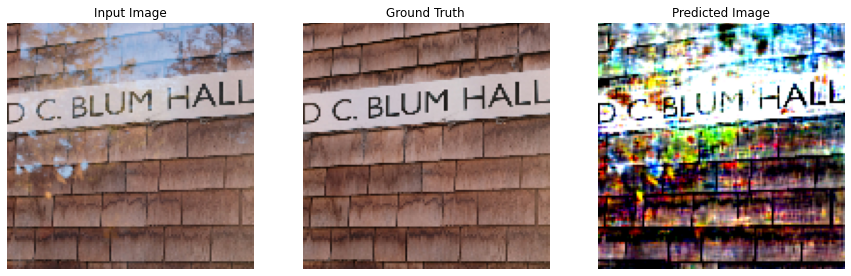

Epoch:  46
....................................................................................................
....................................................................................................
....................................................................................................
...................................................

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

------------------------------------------

Time taken for epoch 78 is 103.81446695327759 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


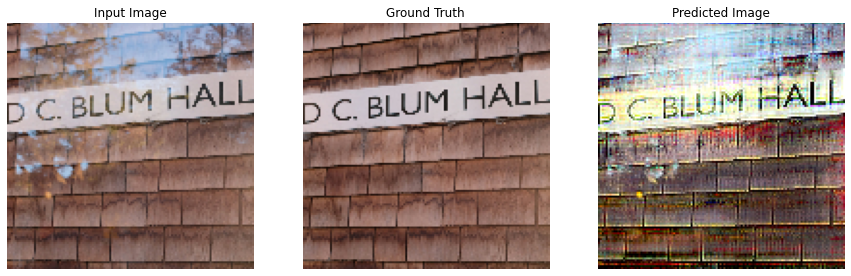

Epoch:  79
.

In [ ]:
# fit(train_dataset, EPOCHS, test_dataset)

## PREDICT

In [ ]:
# ckpt.restore(ckpt_mgr.latest_checkpoint)

In [88]:
!pwd

/home/jupyter/Tin-Final-Proj


In [89]:
checkpoint_dir = './logs/ckpts/ckpt_0610'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(epoch = tf.Variable(0),
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [90]:
checkpoint_manager = tf.train.CheckpointManager(checkpoint= checkpoint,
                                                directory=checkpoint_dir,
                                                max_to_keep=5)

In [91]:
checkpoint_manager.checkpoints

['./logs/ckpts/ckpt_0610/ckpt-9',
 './logs/ckpts/ckpt_0610/ckpt-10',
 './logs/ckpts/ckpt_0610/ckpt-11',
 './logs/ckpts/ckpt_0610/ckpt-12',
 './logs/ckpts/ckpt_0610/ckpt-13']

In [92]:
checkpoint.restore(checkpoint_manager.latest_checkpoint)

In [96]:
checkpoint.restore(checkpoint_manager.checkpoints[2])

In [97]:
checkpoint.epoch.numpy()

110

In [100]:
# for example_input, example_target in test_dataset.take(5):
#     generate_images(generator, example_input, example_target)
    
# for example_input, _, example_target in train_dataset.take(50):
#     generate_images(generator, example_input, example_target)

### Restore the latest checkpoint and test

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))